# Example of using The Module Formerly Known as KDE and Asy_peakbag for KIC7747078

This is a notebook showing a rough draft of the replacement module for KDE and Asy_peakbag, which is currently WIP on the PBjam-dev branch.

We'll start by importing the modeID sampler (Should the name be changed?)

In [1]:
%load_ext autoreload
%autoreload 2
from pbjam.modeID import modeIDsampler
from pbjam import IO
import matplotlib.pyplot as plt
import pbjam.distributions as dist
import jax
import jax.numpy as jnp
 
plt.rcParams['font.size'] = 18
jax.config.update('jax_enable_x64', True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/nielsemb/.local/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/nielsemb/.lightkurve/cache. Please move all the files in the legacy directory /home/nielsemb/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


We'll also use the IO module to load the PSD. This is a new module that contains all I/O related matters, saving/loading/downloading etc. The largest part of this is wrapping the various lightkurve steps to getting a PSD. However it now also stores lightkurve search results so that cached data are loaded more quickly. 

The IO.psd class also normalizes the PSD consistently (Parseval). This is important now that we're working on the PSD and not the SNR spectrum.

In [2]:
ID = 'KIC7747078'

psd = IO.psd(ID, lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})
#psd = IO.psd('TIC95473936', lk_kwargs={'exptime': 120, 'mission':'TESS', 'author':'SPOC'})

psd()

f = psd.freq[::5]

s = psd.powerdensity[::5]

Using cached search result.
Loading fits files from cache.


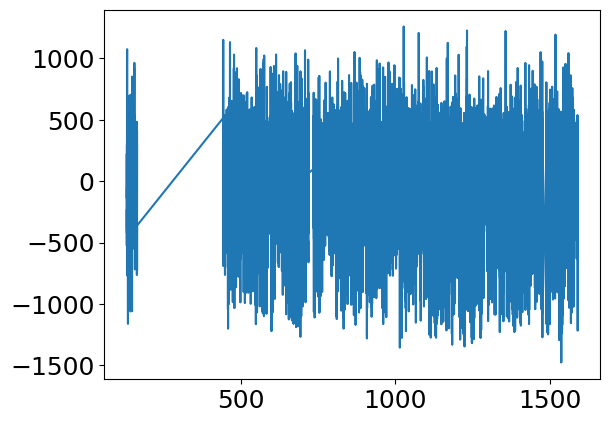

In [3]:
plt.plot(psd._time, psd._flux)

## Priors
With the update to PBjam most of the parameters are included in the dimensionality reduction (DR). The latent parameter priors are constructed by the DR module, using the the prior sample of the model parameters. For the g-mode parameters the prior sample is not even remotely complete however. To get around this we can supply the modeID class with a list of priors for these parameters. They will then automatically be removed from the list of parameters included in the DR.

These priors are all in the form of class instances of distributions, similar to the scipy.stats classes. However, here we're using a set of custom classes that have been jaxed.

In [41]:
addObs = {'numax' : (977, 80),
          'dnu'  : (53.7, 0.21),
          'teff': (5903, 80.0),
          'bp_rp': (0.659, 0.05), 
          } 

addPriors = {'u1' : dist.beta(a=1.2, b=1.2, loc=-0.02, scale=0.09),
             'u2' : dist.beta(a=1.2, b=1.2, loc=0.001, scale=0.08),
             'DPi1': dist.normal(loc=350, scale=350*0.1),
             'eps_g': dist.normal(loc=0.7, scale=0.1),
             'd01': dist.normal(loc=24, scale=1),
             'alpha_g': dist.normal(loc=jnp.log10(0.002), scale=0.5),
            }

In [42]:
N_p = 9

N_pca = 20

PCAdims = 8
 
M = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=N_pca, PCAdims=PCAdims, priorpath=IO.get_priorpath(), freq_limits = [100, 2000])

## Plot the prior
It's always good to check that your prior is reasonable, so lets plot some samples from the prior.

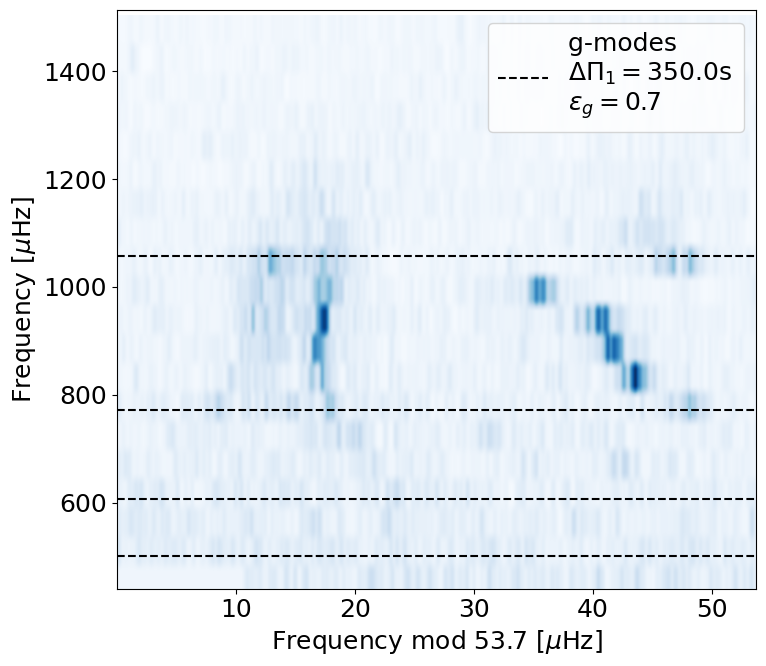

In [43]:
fig, ax = M.echelle(stage='prior') 

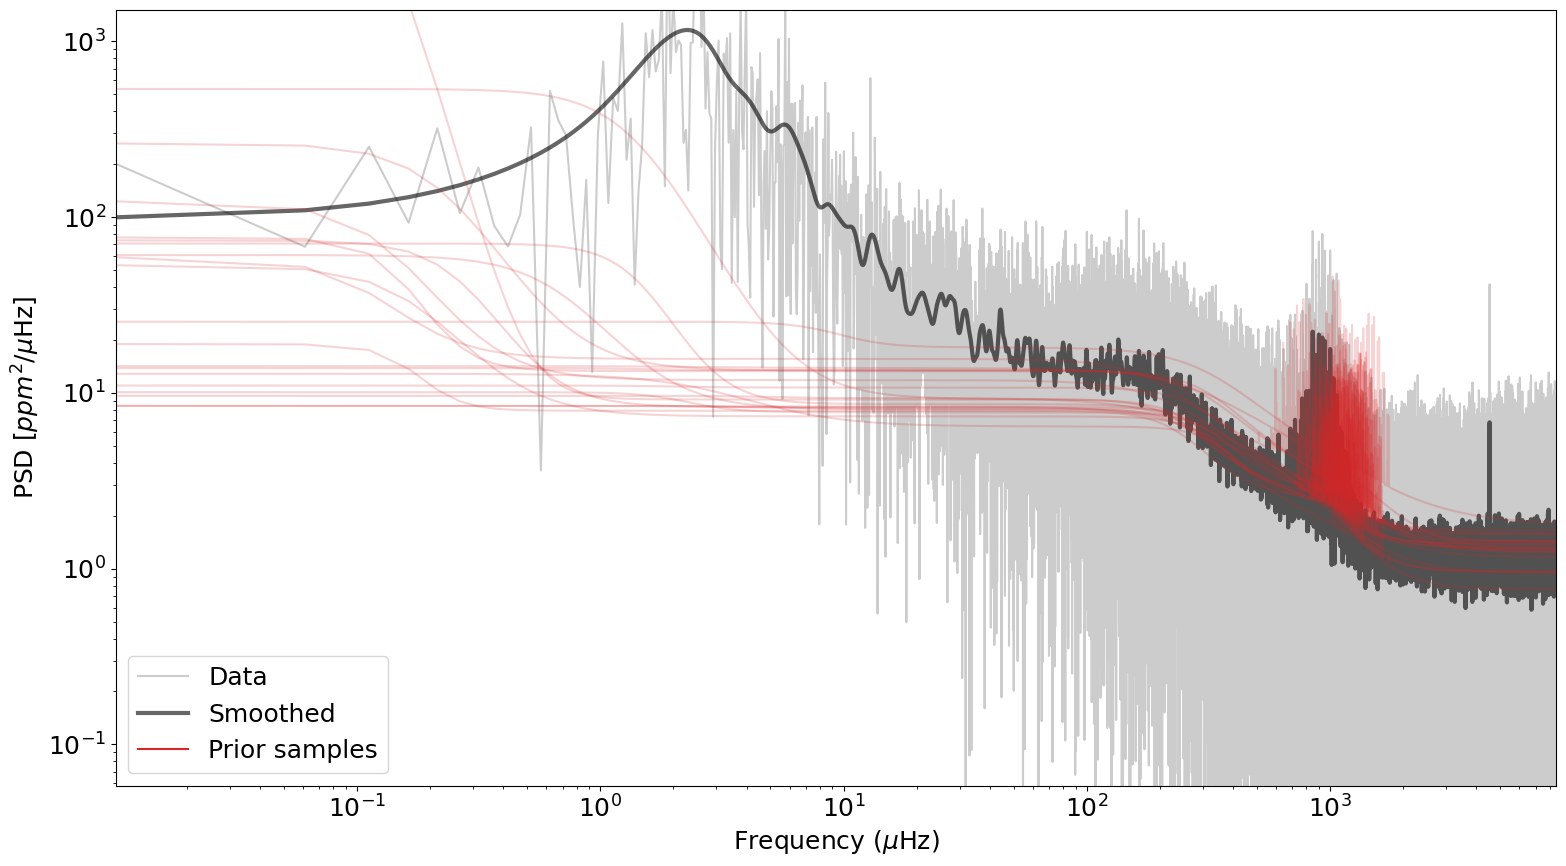

In [44]:
M.spectrum(stage='prior');

## Run Dynesty
Time to run! You can optionally run with the dynamic sampler enabled, but it probably won't do you much good and take an order of magnitude longer.

In [45]:
modeIDsamples, modeIDresult = M(dynesty_kwargs = {'nlive':50*M.ndims})

89717it [52:50, 28.30it/s, +1050 | bound: 560 | nc: 1 | ncall: 3562709 | eff(%):  2.548 | loglstar:   -inf < -73347.768 <    inf | logz: -73433.676 +/-  0.322 | dlogz:  0.002 >  1.059]


## Plot model samples
Time to plot some of the posterior samples

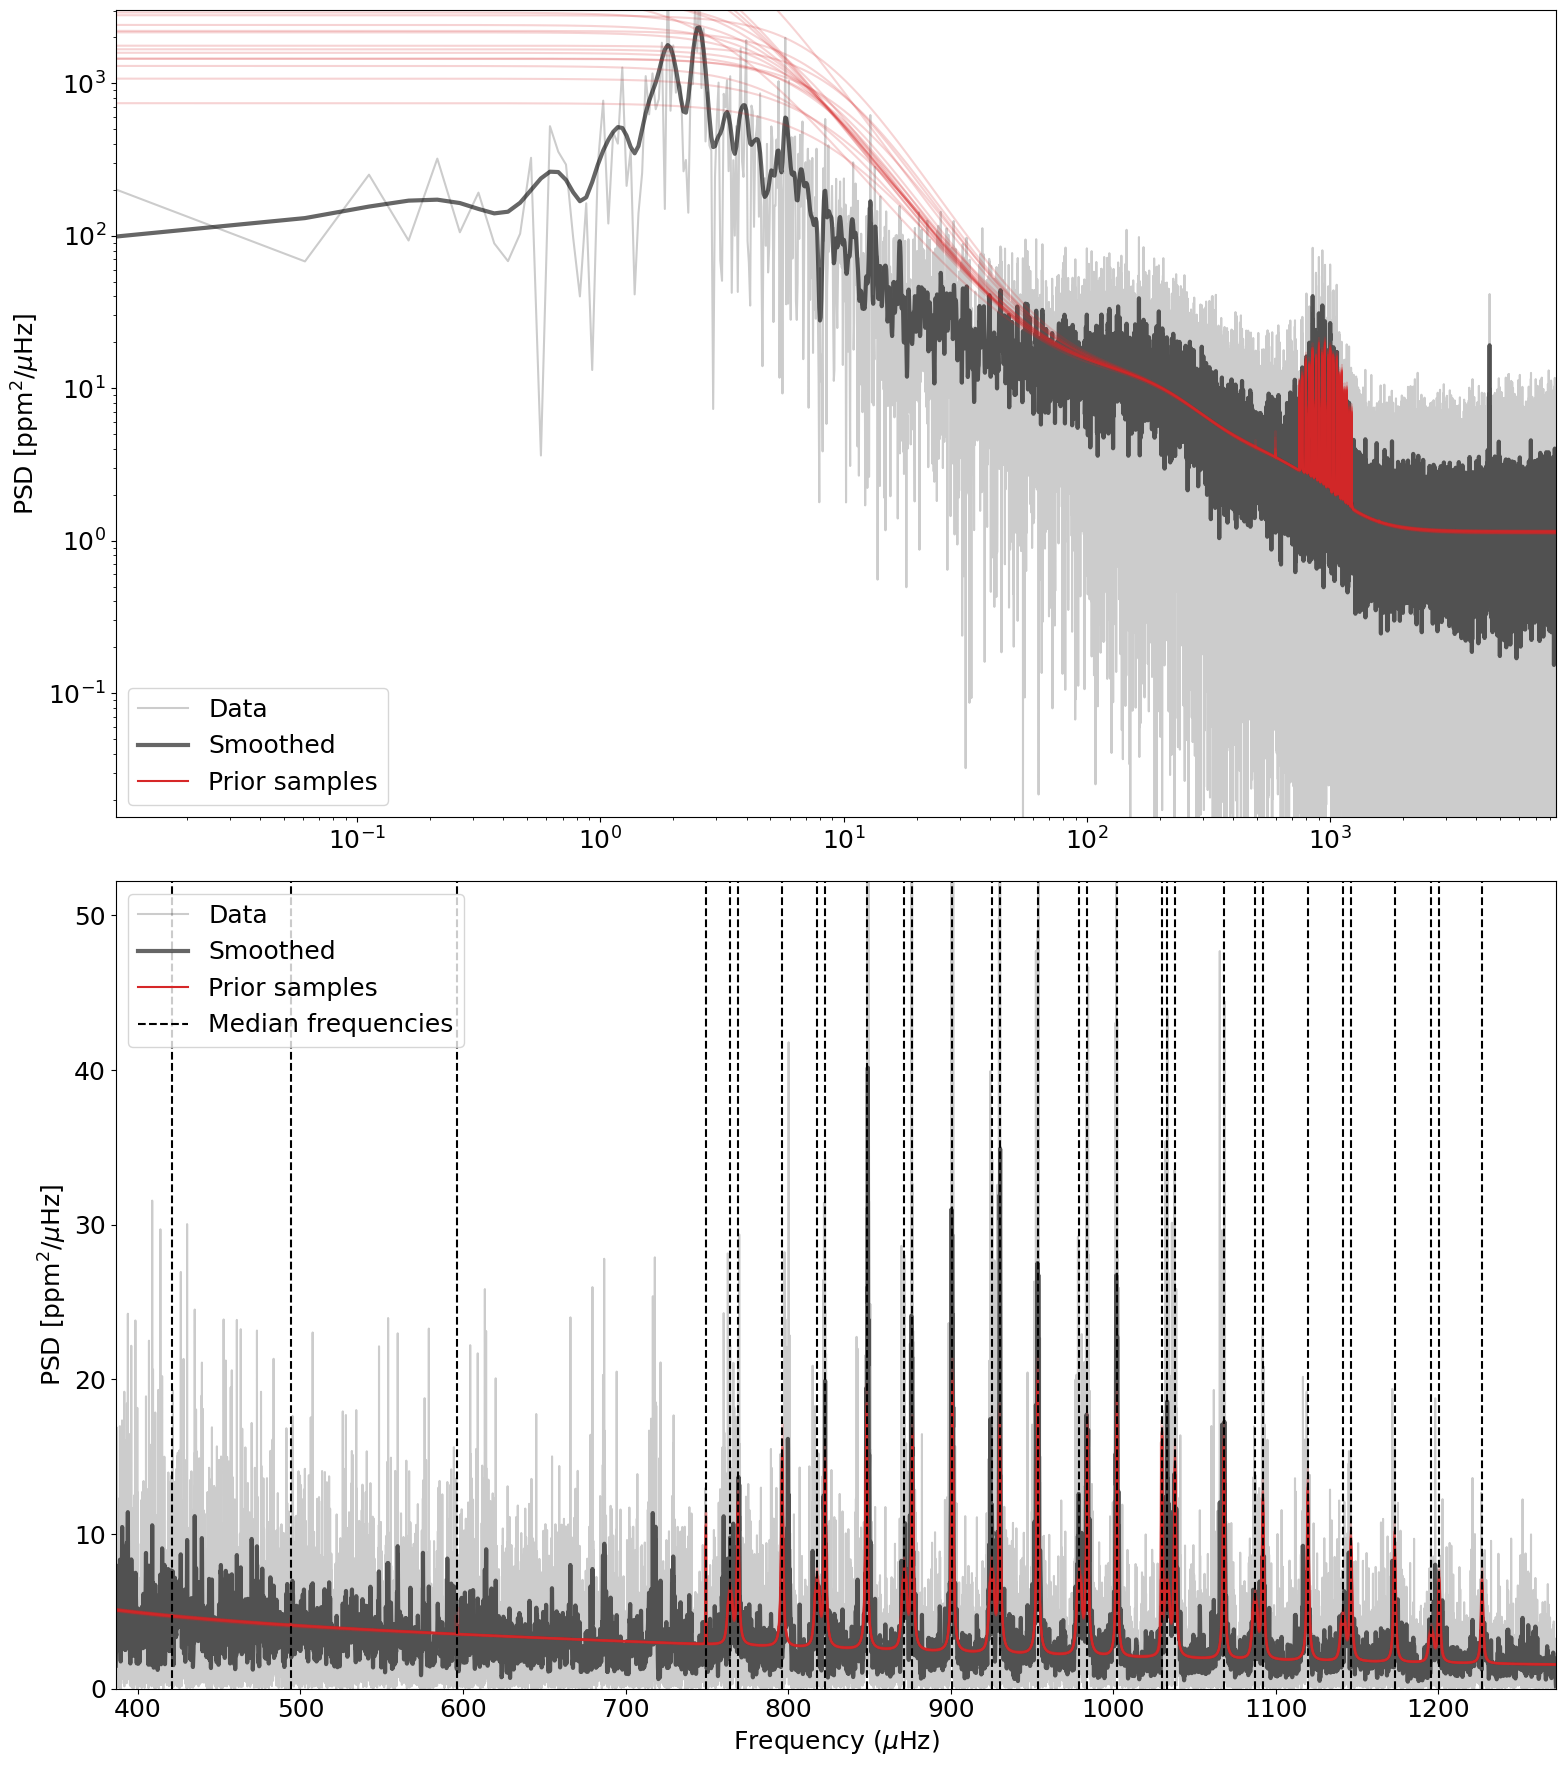

In [46]:
M.spectrum(stage='posterior');

## Corner plot
We can make a nice corner plot too. However, the samples from the priors contain a mix of latent parameters and model parameters, some in log10, others not. To get everything in terms of linear model parameters we'll need to transform the raw samples

In [ ]:
M.plotLatentCorner(M.samples)

In [ ]:
fig, ax = M.echelle(ID=ID);
 
d01 =  M.result['summary']['d01'][0]
DPi1 =  M.result['summary']['DPi1'][0]  
eps_g = M.result['summary']['eps_g'][0] 
alpha_g = M.result['summary']['alpha_g'][0]  
u1 = M.result['summary']['u1'][0]  
u2 = M.result['summary']['u2'][0]  
p_L = jnp.array([(u1 + u2)/jnp.sqrt(2)])  
p_D = jnp.array([(u1 - u2)/jnp.sqrt(2)])  

numax = M.result['summary']['numax'][0]
dnu = M.result['summary']['dnu'][0]  
eps_p = M.result['summary']['eps_p'][0]
alpha_p = M.result['summary']['alpha_p'][0]

nu0_p, n_p = M.AsyFreqModel.asymptotic_nu_p(numax, dnu, eps_p, alpha_p)
nu_g = M.MixFreqModel.asymptotic_nu_g(M.MixFreqModel.n_g, DPi1, eps_g, alpha_g )
nu_m, zeta = M.MixFreqModel.mixed_nu1(nu0_p, n_p, d01, DPi1, p_L, p_D, eps_g, alpha_g)
ax.scatter(nu_m%dnu, nu_m, c='C5', zorder=99, label='Summary stats', s=50, ec='w')

In [ ]:
for key in M.result['summary'].keys():
    print(key, M.result['summary'][key][0])